<a href="https://colab.research.google.com/github/Dylan-Geraci/neuroimaging-tumor-detector/blob/main/notebooks/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training

## Notebook Setup

Import Libraries

In [20]:
# --- Standard ---
import os, json, math, time
from collections import Counter

# --- Numerical / data ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Imaging & plotting ---
from PIL import Image

# --- Torch / ML ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Metrics ---
from sklearn.metrics import f1_score, accuracy_score

# --- Vision ---
from torchvision import transforms

# --- Pretrained models ---
import timm

# --- Google Drive ---
from google.colab import drive

import time, json, torch
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix

Set Training Data Path

In [4]:
drive.mount('/content/drive')
TRAIN_PATH = "/content/drive/MyDrive/neuro-imaging/data/Training"

Mounted at /content/drive


In [5]:
USE_SAVED_SPLITS = False
SPLITS_DIR = "/content/drive/MyDrive/neuro-imaging/splits"

## Path and Constants

In [6]:
TRAIN_PATH = "/content/drive/MyDrive/neuro-imaging/data/Training"
SPLITS_DIR = "/content/drive/MyDrive/neuro-imaging/splits"
OUT_DIR    = "/content/drive/MyDrive/neuro-imaging/models"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
LR = 3e-4
EPOCHS = 10
PATIENCE = 2
SEED = 42

## Reproducing

In [7]:
def set_seed(seed=SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Load Splits and Class Maps

In [8]:
def _read_paths(txt_path):
    with open(txt_path, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

with open(os.path.join(SPLITS_DIR, "class_to_idx.json"), "r") as f:
    class_to_idx = json.load(f)
idx_to_class = {v:k for k,v in class_to_idx.items()}
num_classes = len(class_to_idx)
print("Classes:", [idx_to_class[i] for i in range(num_classes)])

train_paths = _read_paths(os.path.join(SPLITS_DIR, "train.txt"))
val_paths   = _read_paths(os.path.join(SPLITS_DIR, "val.txt"))
print(f"Loaded {len(train_paths)} train, {len(val_paths)} val files")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Loaded 4855 train, 857 val files


## Transforms

In [9]:
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

## Dataset from path list

In [10]:
class PathDataset(Dataset):
    def __init__(self, paths, class_to_idx, transform=None):
        self.paths = paths
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        p = self.paths[i]
        cls_name = os.path.basename(os.path.dirname(p))
        y = self.class_to_idx[cls_name]
        img = Image.open(p)
        if self.transform:
            img = self.transform(img)
        return img, y

train_ds = PathDataset(train_paths, class_to_idx, train_tfms)
val_ds   = PathDataset(val_paths,   class_to_idx, val_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## Class weights (handle imbalances)

In [11]:
train_counts = Counter([os.path.basename(os.path.dirname(p)) for p in train_paths])
counts_by_idx = np.array([train_counts[idx_to_class[i]] for i in range(num_classes)], dtype=np.float32)
weights = (len(train_paths) / (num_classes * counts_by_idx))
class_weights = torch.tensor(weights, dtype=torch.float32, device=device)
print("Class weights:", weights.tolist())

Class weights: [1.080810308456421, 1.0665642023086548, 0.8950958847999573, 0.980411946773529]


## Model, loss, optimizer, scaler

In [12]:
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-3194161557.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


## Train / eval helpers

In [13]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_targets = [], []
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    f1_macro = f1_score(all_targets, all_preds, average="macro")
    return {"loss": val_loss, "acc": acc, "f1_macro": f1_macro}

def train_one_epoch(model, loader, device):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## Training loop with early stopping on val macro-F1

Copying data to local

In [12]:
import torch, os, subprocess, textwrap
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    try:
        print(subprocess.check_output(["nvidia-smi"], text=True))
    except Exception:
        pass

!mkdir -p /content/data/Training
!rsync -ah --delete --info=progress2 "/content/drive/MyDrive/neuro-imaging/data/Training/" "/content/data/Training/"

CUDA available: True
Mon Aug 25 21:00:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             28W /   70W |     136MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

In [13]:
import os, time, json, numpy as np, torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PIN = device.type == "cuda"
NUM_WORKERS = 2 if PIN else 0
print("Device:", device)

DRIVE_ROOT = "/content/drive/MyDrive/neuro-imaging/data/Training"
LOCAL_ROOT = "/content/data/Training"
if os.path.isdir(LOCAL_ROOT):
    train_paths = [p.replace(DRIVE_ROOT, LOCAL_ROOT) for p in train_paths]
    val_paths   = [p.replace(DRIVE_ROOT, LOCAL_ROOT) for p in val_paths]
    train_ds.paths, val_ds.paths = train_paths, val_paths
    print("Using LOCAL data:", LOCAL_ROOT)

USE_LIGHT_MODEL_ON_CPU = True
if device.type != "cuda" and USE_LIGHT_MODEL_ON_CPU:
    import timm
    model = timm.create_model("mobilenetv3_small_075", pretrained=True, num_classes=len(class_to_idx)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    print("Switched to MobileNetV3 small for CPU speed.")

dl_kwargs = dict(batch_size=BATCH_SIZE, pin_memory=PIN)
if NUM_WORKERS > 0:
    dl_kwargs.update(num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)
else:
    dl_kwargs.update(num_workers=0)
train_dl = DataLoader(train_ds, shuffle=True,  **dl_kwargs)
val_dl   = DataLoader(val_ds,   shuffle=False, **dl_kwargs)

scaler = GradScaler(enabled=PIN)

#Helpers
@torch.no_grad()
def evaluate(model, loader):
    from sklearn.metrics import accuracy_score, f1_score
    model.eval()
    total_loss, preds_all, targs_all = 0.0, [], []
    for x, y in loader:
        x = x.to(device, non_blocking=PIN); y = y.to(device, non_blocking=PIN)
        with autocast(device_type="cuda", enabled=PIN):
            logits = model(x); loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds_all.append(torch.argmax(logits, 1).cpu().numpy())
        targs_all.append(y.cpu().numpy())
    preds = np.concatenate(preds_all); targs = np.concatenate(targs_all)
    return {"loss": total_loss/len(loader.dataset),
            "acc": float((preds==targs).mean()),
            "f1_macro": float(f1_score(targs, preds, average="macro"))}

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=PIN); y = y.to(device, non_blocking=PIN)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=PIN):
            logits = model(x); loss = criterion(logits, y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

BEST_PATH = os.path.join(OUT_DIR, "best.pt")
LAST_PATH = os.path.join(OUT_DIR, "last.pt")
best = {"f1": -1.0, "epoch": 0}

start_epoch = 1
if os.path.exists(LAST_PATH):
    try:
        ckpt = torch.load(LAST_PATH, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        start_epoch = int(ckpt.get("epoch", 0)) + 1
        best["f1"] = float(ckpt.get("best_f1", -1.0))
        best["epoch"] = int(ckpt.get("best_epoch", 0))
        print(f"Resumed from epoch {start_epoch-1} (best F1={best['f1']:.4f})")
    except Exception as e:
        print("Resume failed (starting fresh):", e)

EPOCHS_RUN = min(EPOCHS, 6)
PATIENCE = 1
MAX_MINUTES = 20
t0 = time.time()
history = []
patience_left = PATIENCE

try:
    for epoch in range(start_epoch, start_epoch + EPOCHS_RUN):
        train_loss = train_one_epoch(model, train_dl)
        val_metrics = evaluate(model, val_dl)
        log = {"epoch": epoch,
               "train_loss": float(train_loss),
               "val_loss": float(val_metrics["loss"]),
               "val_acc": float(val_metrics["acc"]),
               "val_f1_macro": float(val_metrics["f1_macro"]),
               "time_sec": float(time.time()-t0)}
        history.append(log); print(log)

        torch.save({"model_state_dict": model.state_dict(),
                    "epoch": epoch,
                    "best_f1": best["f1"],
                    "best_epoch": best["epoch"]}, LAST_PATH)

        if val_metrics["f1_macro"] > best["f1"] + 1e-6:
            best.update({"f1": val_metrics["f1_macro"], "epoch": epoch})
            torch.save({"model_state_dict": model.state_dict(),
                        "class_to_idx": class_to_idx,
                        "img_size": IMG_SIZE},
                       BEST_PATH)
            patience_left = PATIENCE
        else:
            patience_left -= 1

        if patience_left <= 0:
            print(f"Early stopping at epoch {epoch} (best epoch {best['epoch']}, F1={best['f1']:.4f})")
            break

        if (time.time() - t0) > MAX_MINUTES * 60:
            print(f"Time cap reached (~{MAX_MINUTES} min).")
            break

finally:
    with open(os.path.join(OUT_DIR, "train_log.json"), "w") as f:
        json.dump(history, f, indent=2)

print("Best:", best, "| Checkpoints:", {"best": os.path.basename(BEST_PATH), "last": os.path.basename(LAST_PATH)})


Device: cuda
Using LOCAL data: /content/data/Training
Resumed from epoch 4 (best F1=0.9858)
{'epoch': 5, 'train_loss': 0.08445280406185993, 'val_loss': 0.09135677819542343, 'val_acc': 0.9731621936989499, 'val_f1_macro': 0.9720730465349766, 'time_sec': 56.08293557167053}
Early stopping at epoch 5 (best epoch 3, F1=0.9858)
Best: {'f1': 0.985811140155392, 'epoch': 3} | Checkpoints: {'best': 'best.pt', 'last': 'last.pt'}


## Loading Trained Model and Testing
You can starting running from here and libraries at the top

Load best checkpoint

In [16]:
ckpt = torch.load(os.path.join(OUT_DIR, "best.pt"), map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Predict on the validation set (no augmentation)

In [17]:
preds, targs, files = [], [], []
for p in val_paths:
    img = Image.open(p)
    x = val_tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        pred = int(logits.argmax(1).item())
    preds.append(pred)
    cls_name = os.path.basename(os.path.dirname(p))
    targs.append(int(class_to_idx[cls_name]))
    files.append(p)

Metrics

              precision    recall  f1-score   support

      glioma     1.0000    0.9798    0.9898       198
  meningioma     0.9614    0.9900    0.9755       201
     notumor     0.9916    0.9874    0.9895       239
   pituitary     0.9908    0.9863    0.9886       219

    accuracy                         0.9860       857
   macro avg     0.9859    0.9859    0.9858       857
weighted avg     0.9862    0.9860    0.9860       857



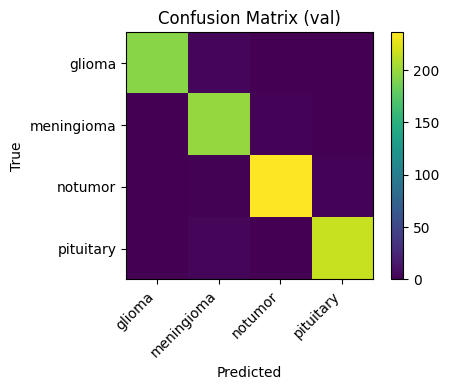

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
target_names = [idx_to_class[i] for i in range(num_classes)]
print(classification_report(targs, preds, target_names=target_names, digits=4))

cm = confusion_matrix(targs, preds, labels=list(range(num_classes)))
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (val)")
plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, target_names, rotation=45, ha="right")
plt.yticks(ticks, target_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_val.png"), dpi=150, bbox_inches="tight")
plt.show()

Save per-file predictions and misclassifications

In [19]:
df_preds = pd.DataFrame({
    "file": files,
    "true": [idx_to_class[t] for t in targs],
    "pred": [idx_to_class[p] for p in preds],
})
df_preds.to_csv(os.path.join(OUT_DIR, "val_predictions.csv"), index=False)
df_preds[df_preds.true != df_preds.pred].to_csv(os.path.join(OUT_DIR, "val_misclassified.csv"), index=False)